In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


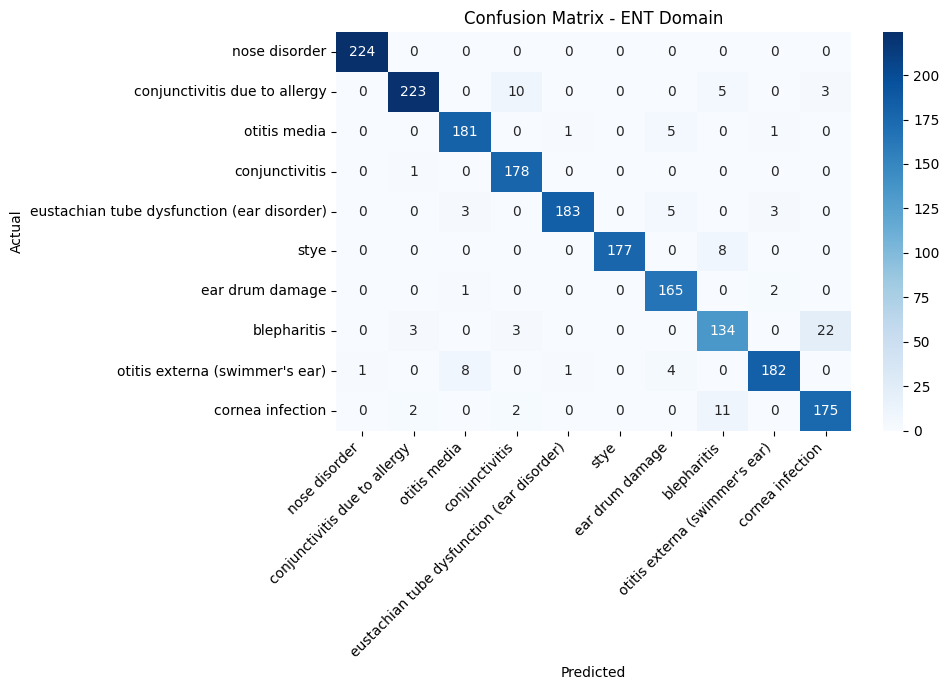

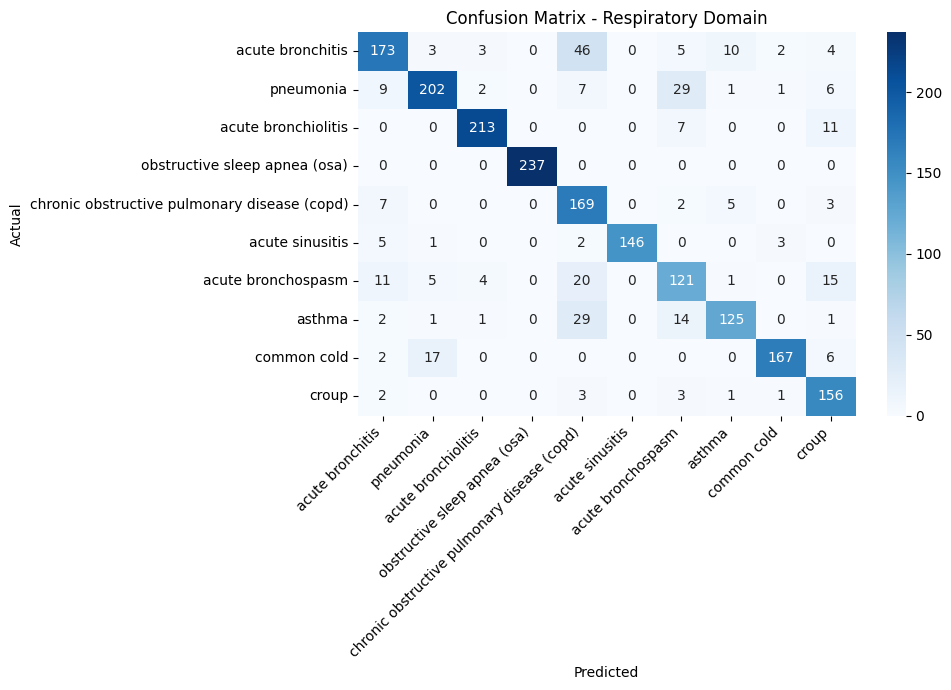

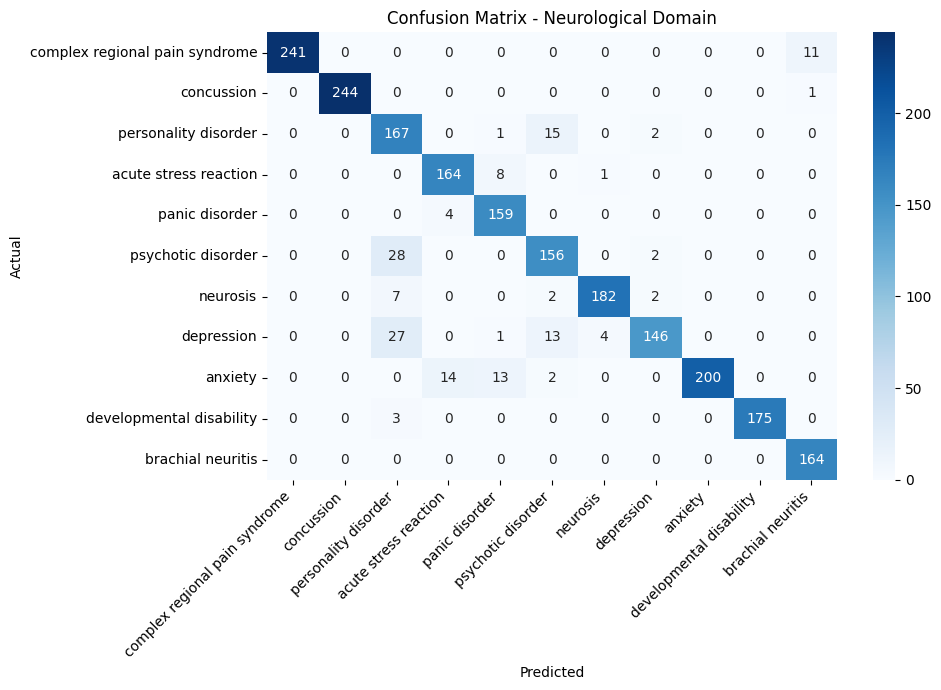

In [4]:
!pip install datasets
!pip install seaborn matplotlib
!pip install datasets
import torch
import pandas as pd
import numpy as np
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Load model and tokenizer ===
model_path = "/content/drive/MyDrive/DB/biobert_finetuned"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
model.eval()

# === 2. Load disease mapping ===
with open(f"{model_path}/id_to_disease.json", "r") as f:
    id_to_disease = {int(k): v for k, v in json.load(f).items()}
disease_to_id = {v: k for k, v in id_to_disease.items()}

# === 3. Load and preprocess dataset ===
df = pd.read_csv("/content/drive/MyDrive/DB/ENT_respiratory_neurological.csv")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
df["Symptoms"] = df["Symptoms"].str.lower().str.strip()
df["Label"] = df["Disease"].map(disease_to_id).astype(int)

# === 4. Split data into test set ===
_, test_texts, _, test_labels = train_test_split(
    df["Symptoms"].tolist(), df["Label"].tolist(), test_size=0.2, random_state=42
)

# === 5. Tokenize test data ===
def tokenize_fn(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

# === 6. Predict on test data ===
all_preds = []
batch_size = 16
model.eval()

for i in range(0, len(test_texts), batch_size):
    batch_texts = test_texts[i:i+batch_size]
    inputs = tokenize_fn(batch_texts).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
    all_preds.extend(batch_preds)

# === 7. Domain definitions (update based on your real dataset) ===
domain_mapping = {
    "ENT": [
        "nose disorder",
        "conjunctivitis due to allergy",
        "otitis media",
        "conjunctivitis",
        "eustachian tube dysfunction (ear disorder)",
        "stye",
        "ear drum damage",
        "blepharitis",
        "otitis externa (swimmer's ear)",
        "cornea infection"
    ],
    "Respiratory": [
        "acute bronchitis",
        "pneumonia",
        "acute bronchiolitis",
        "obstructive sleep apnea (osa)",
        "chronic obstructive pulmonary disease (copd)",
        "acute sinusitis",
        "acute bronchospasm",
        "asthma",
        "common cold",
        "croup"
    ],
    "Neurological": [
        "complex regional pain syndrome",
        "concussion",
        "personality disorder",
        "acute stress reaction",
        "panic disorder",
        "psychotic disorder",
        "neurosis",
        "depression",
        "anxiety",
        "developmental disability",
        "brachial neuritis"
    ]
}

domain_label_ids = {
    domain: [disease_to_id[d] for d in diseases]
    for domain, diseases in domain_mapping.items()
}

test_labels = np.array(test_labels)
all_preds = np.array(all_preds)

# === 8. Plot confusion matrix per domain ===
# === 8. Plot confusion matrix per domain (safe version) ===
for domain, label_ids in domain_label_ids.items():
    mask = np.isin(test_labels, label_ids)
    y_true = test_labels[mask]
    y_pred = all_preds[mask]

    # Remap global IDs to local (0–n)
    global_to_local = {gid: lid for lid, gid in enumerate(label_ids)}

    # Filter out predictions not in current domain
    valid_indices = [i for i, y in enumerate(y_pred) if y in global_to_local]
    y_true = y_true[valid_indices]
    y_pred = y_pred[valid_indices]

    y_true_local = [global_to_local[y] for y in y_true]
    y_pred_local = [global_to_local[y] for y in y_pred]

    class_names = [id_to_disease[gid] for gid in label_ids]

    # Handle case where no valid predictions exist
    if not y_true_local or not y_pred_local:
        print(f"Skipping {domain} - No valid predictions for this domain.")
        continue

    cm = confusion_matrix(y_true_local, y_pred_local)

    # Plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {domain} Domain")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



In [6]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# === 9. Pretty domain-wise metrics ===
for domain, label_ids in domain_label_ids.items():
    mask = np.isin(test_labels, label_ids)
    y_true = test_labels[mask]
    y_pred = all_preds[mask]

    global_to_local = {gid: lid for lid, gid in enumerate(label_ids)}

    # Filter valid predictions for this domain
    valid_indices = [i for i, y in enumerate(y_pred) if y in global_to_local]
    y_true = y_true[valid_indices]
    y_pred = y_pred[valid_indices]

    y_true_local = [global_to_local[y] for y in y_true]
    y_pred_local = [global_to_local[y] for y in y_pred]

    class_names = [id_to_disease[gid] for gid in label_ids]

    if not y_true_local or not y_pred_local:
        print(f"Skipping {domain} - No valid predictions for this domain.\n")
        continue

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true_local, y_pred_local, labels=list(range(len(class_names))), zero_division=0
    )

    accuracy = accuracy_score(y_true_local, y_pred_local)
    macro_avg = [
        np.mean(precision),
        np.mean(recall),
        np.mean(f1),
        np.sum(support)
    ]
    weighted_avg = [
        np.average(precision, weights=support),
        np.average(recall, weights=support),
        np.average(f1, weights=support),
        np.sum(support)
    ]

    print(f"\n📊 === Classification Report for {domain} Domain ===")
    print(f"{'Idx':<5}{'Class':<40}{'Precision':<10}{'Recall':<10}{'F1-score':<10}{'Support':<10}")
    print("-" * 80)
    for idx, name in enumerate(class_names):
        print(f"{idx:<5}{name:<40}{precision[idx]:<10.4f}{recall[idx]:<10.4f}{f1[idx]:<10.4f}{support[idx]:<10}")

    print("-" * 80)
    print(f"{'':<45}accuracy    {accuracy:<10.4f}{int(np.sum(support))}")
    print(f"{'':<45}macro avg   {macro_avg[0]:<10.4f}{macro_avg[1]:<10.4f}{macro_avg[2]:<10.4f}{int(macro_avg[3])}")
    print(f"{'':<45}weighted avg{weighted_avg[0]:<10.4f}{weighted_avg[1]:<10.4f}{weighted_avg[2]:<10.4f}{int(weighted_avg[3])}")



📊 === Classification Report for ENT Domain ===
Idx  Class                                   Precision Recall    F1-score  Support   
--------------------------------------------------------------------------------
0    nose disorder                           0.9956    1.0000    0.9978    224       
1    conjunctivitis due to allergy           0.9738    0.9253    0.9489    241       
2    otitis media                            0.9378    0.9628    0.9501    188       
3    conjunctivitis                          0.9223    0.9944    0.9570    179       
4    eustachian tube dysfunction (ear disorder)0.9892    0.9433    0.9657    194       
5    stye                                    1.0000    0.9568    0.9779    185       
6    ear drum damage                         0.9218    0.9821    0.9510    168       
7    blepharitis                             0.8481    0.8272    0.8375    162       
8    otitis externa (swimmer's ear)          0.9681    0.9286    0.9479    196       
9    corn